In [28]:
import pandas as pd
import mc_processor
import os
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import numpy as np
import visualizing

import importlib
# importlib.reload(mc_processor)
importlib.reload(visualizing)

%matplotlib inline
%config InlineBackend.figure_format = 'png'



In [29]:
survey_year = str(2024)

In [30]:
# field1 = pd.read_csv(os.path.join(survey_year,'raw/field1/data.csv'), encoding='utf-8')
# field1.drop([q for q in field1.columns if q.startswith("BPC4")],axis=1)
# field2 = pd.read_csv(os.path.join(survey_year,'raw/field2/rvoter/data.csv'), encoding='utf-8')

# # join the two fields assuming reweights will produce minimal effects
# joined_data = pd.concat([field1,field2],axis=1)

In [31]:
# read results files

clarifier = "field2/rvoter/"
# clarifier = ""

codebook = pd.read_csv(os.path.join(survey_year,f'raw/levels_codebook.csv'), encoding='utf-8')
data = pd.read_csv(os.path.join(survey_year,f'raw/{clarifier}data.csv'), encoding='utf-8')
q_codebook = pd.read_csv(os.path.join(survey_year,f'raw/question_codebook.csv'), encoding='utf-8', index_col = 'qid')

# q_codebook into dict
q_codebook = q_codebook.to_dict().get('qidFull')

In [32]:
data.head(2)

ResponseID  xdemAll  demZIP  BPC1_1  BPC1_2  BPC1_3  BPC1_4  BPC1_5  \
0  R_7IawucEjaAD7m62        1   62871       4       3       4       4       4   
1  R_5PvmPKlU3zhT6Ip        1   15323       3       3       4       4       4   

   BPC2_1NET  BPC2_2NET  ...  demLGBTQ1  xdemMarried  BPCxdem1  BPCxdem2  \
0          1          2  ...          1            2         1         2   
1          2          2  ...          1            2         1         2   

   BPCxdem3  BPCxdem4  BPCxdem5  county_fips  demGender       wts  
0         2         1       1.0      17059.0        2.0  0.074423  
1         2         1       2.0      42125.0        2.0  0.282081  

[2 rows x 219 columns]

In [33]:
nulldata = pd.DataFrame(data.isnull().sum(),columns=["Sum_Null"]) ##2204 rows in 2024
nulldata.sort_values(by=["Sum_Null"],ascending=False,inplace=True)

# nulldata[nulldata["Sum_Null"]>0].head(20)

In [34]:
# all demo categories
for key in q_codebook:
    if "dem" in key:
        print(key)

xdemAll
demZIP
xdemGender
demAgeGeneration
xdemIdeo3
xdemInc3
xdemWhite
xdemHispBin
demBlackBin
demRaceOther
xdemReligion
xdemReligOther
xdemEvang
xdemUsr
xdemEmploy
xdemMilHH1
xdemBidenApprove
xdemBidenApprove2
demInsured
demInsType
demUnion
demLGBTQ1
xdemMarried
BPCxdem1
BPCxdem2
BPCxdem3
BPCxdem4
BPCxdem5
demGender3
demRVoter


In [36]:
##CONFIDENCE RATES

#save individual csvs for confidence by xpid3
confidence_keys = {20:"Your vote",21:"Votes in your local community",22:"Votes in your state",23:"Votes across the country"}

dfs = {}

for i in range(20, 24):
    df = mc_processor.get_confidence_results(data, codebook, q_codebook, question_number=i, demo='xpid3', suppress_output=True)
    dfs[confidence_keys[i]] = df
    df = df.map(lambda x: f"{x:.1%}")
    df.to_csv(f"2024/charts/BPC{i}.csv")


In [37]:
##PLOT OVERALL CONFIDENCE RATES

demo = None
question_number = 20

dfs = []
cols = []
for i in range(20,24):
    dfs.append(mc_processor.get_confidence_results(data,codebook,q_codebook,i,demo=None,suppress_output=True))#.map(lambda x: f"{x:.1%}"))
    cols.append(q_codebook[f"BPC{i}a"])

confidence = pd.concat(dfs, axis=1)
confidence.columns = cols

# visualizing.plot_overall_confidence(confidence)

In [38]:
##PLOT CONFIDENCE SPLIT SAMPLES
#split sample a - regular order
#split sample b - reverse order
#split sample c - random order

sample_dict = {"a":"regular order","b":"reverse order","c":"random order"}

all_dfs = []

for i in range(20,24):
    # store dfs for each sample
    q_dfs = []    
    for split_sample in ["a","b","c"]:
        question = "BPC"+str(i)+split_sample
    
        # get results for question by sample
        df = mc_processor.run_and_display(data,codebook,q_codebook,question,survey_year,demo=None,suppress_output=True)
        df.columns = [f"{sample_dict[split_sample]}"]
        q_dfs.append(df)
    
    # print(q_codebook[question]) # defaults to split sample c, but tested with other a/b/c combos and got same result (they rotated question order but didn't change question #)
    

    q_df = pd.concat(q_dfs, axis=1)

    q_df["deviation"] = q_df.std(axis=1)

    ## display df with formatted percents
    # display(q_df.iloc[:,0:3].map(lambda x: f"{x:.1%}"))

    all_dfs.append(q_df)

# visualizing.plot_split_sample(all_dfs, q_codebook)

# # get n for split samples
# for sample in ["a","b","c"]:
#     # for q in range(20,24):
#     q = 20
#     print(data[[f"BPC{q}{sample}"]].count())

In [39]:
##DOT PLOT CHANGE IN CONFIDENCE 23 -> 24

importlib.reload(visualizing)

confidence2024 = confidence
confidence2023 = pd.read_csv("2023/confidence.csv",index_col=0)

# cols
confidence2023.columns = list(confidence_keys.values())
confidence2024.columns = list(confidence_keys.values())


confidence_23_24 = []
dfs= [confidence2023,confidence2024]
years  = ["2023","2024"]
for i in range(2):
    df = dfs[i].T
    df[years[i]] = df[["Very confident","Somewhat confident"]].sum(axis=1)
    df = df[[years[i]]]
    confidence_23_24.append(df)

confidence_23_24 = pd.concat(confidence_23_24,axis=1)

# visualizing.dotplot(confidence_23_24,"confidence",start_tick_title = "Oct' 23", end_tick_title = "Dec' 24",xlabel='Percent Very or Somewhat Confident')


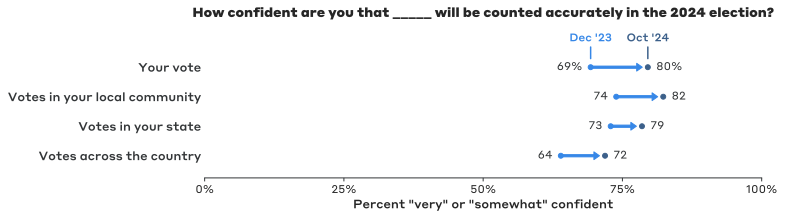

In [40]:
%config InlineBackend.figure_format = 'svg'

importlib.reload(visualizing)
visualizing.dotplot2(confidence_23_24,
                     'confidence_23_24.png',
                     start_tick_title = "Dec '23",
                     end_tick_title = "Oct '24",
                     xlabel='Percent "very" or "somewhat" confident',
                     title='How confident are you that _____ will be counted accurately in the 2024 election?')


In [41]:
# store demo results in processed folder
demos = ['xpid3','age']
questions = [f"BPC{i}" for i in range(1, 20)] + ['BPC24']

for demo in demos:
     for question in questions:
          mc_processor.run_and_display(data,codebook,q_codebook,question,survey_year,demo,suppress_output=True)

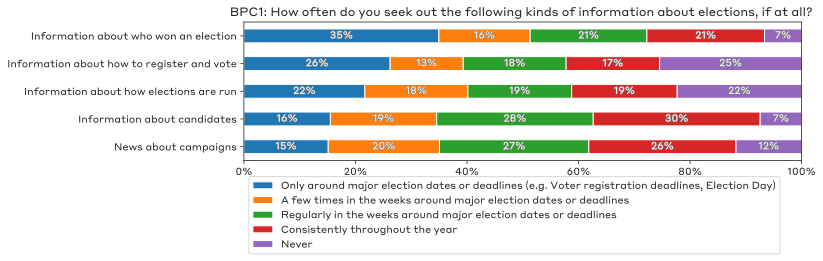

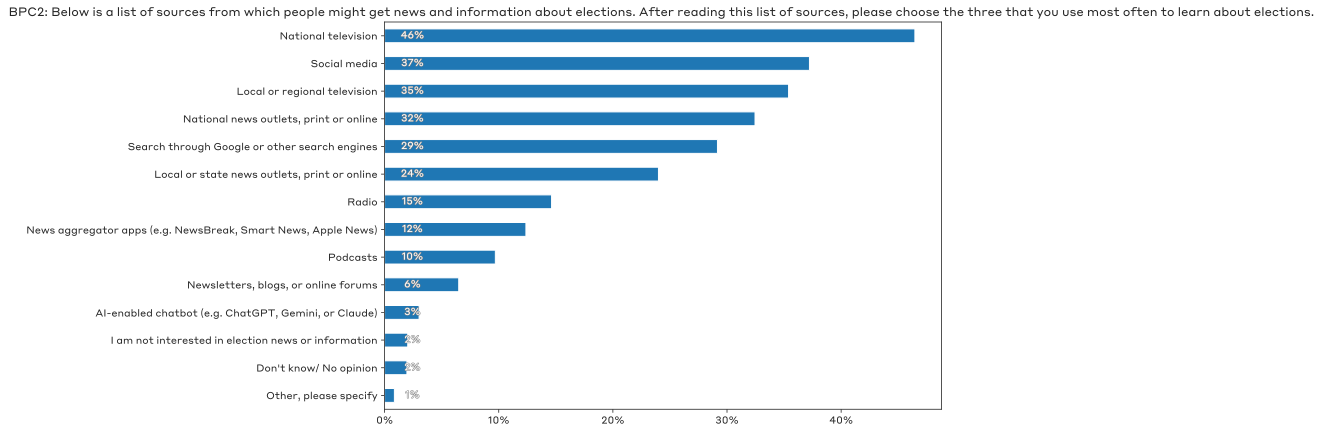

In [42]:
demo = None

questions = [f"BPC{i}" for i in range(1, 3)]

for question in questions:
     df = mc_processor.run_and_display(data,codebook,q_codebook,question,survey_year,demo,suppress_output=False)

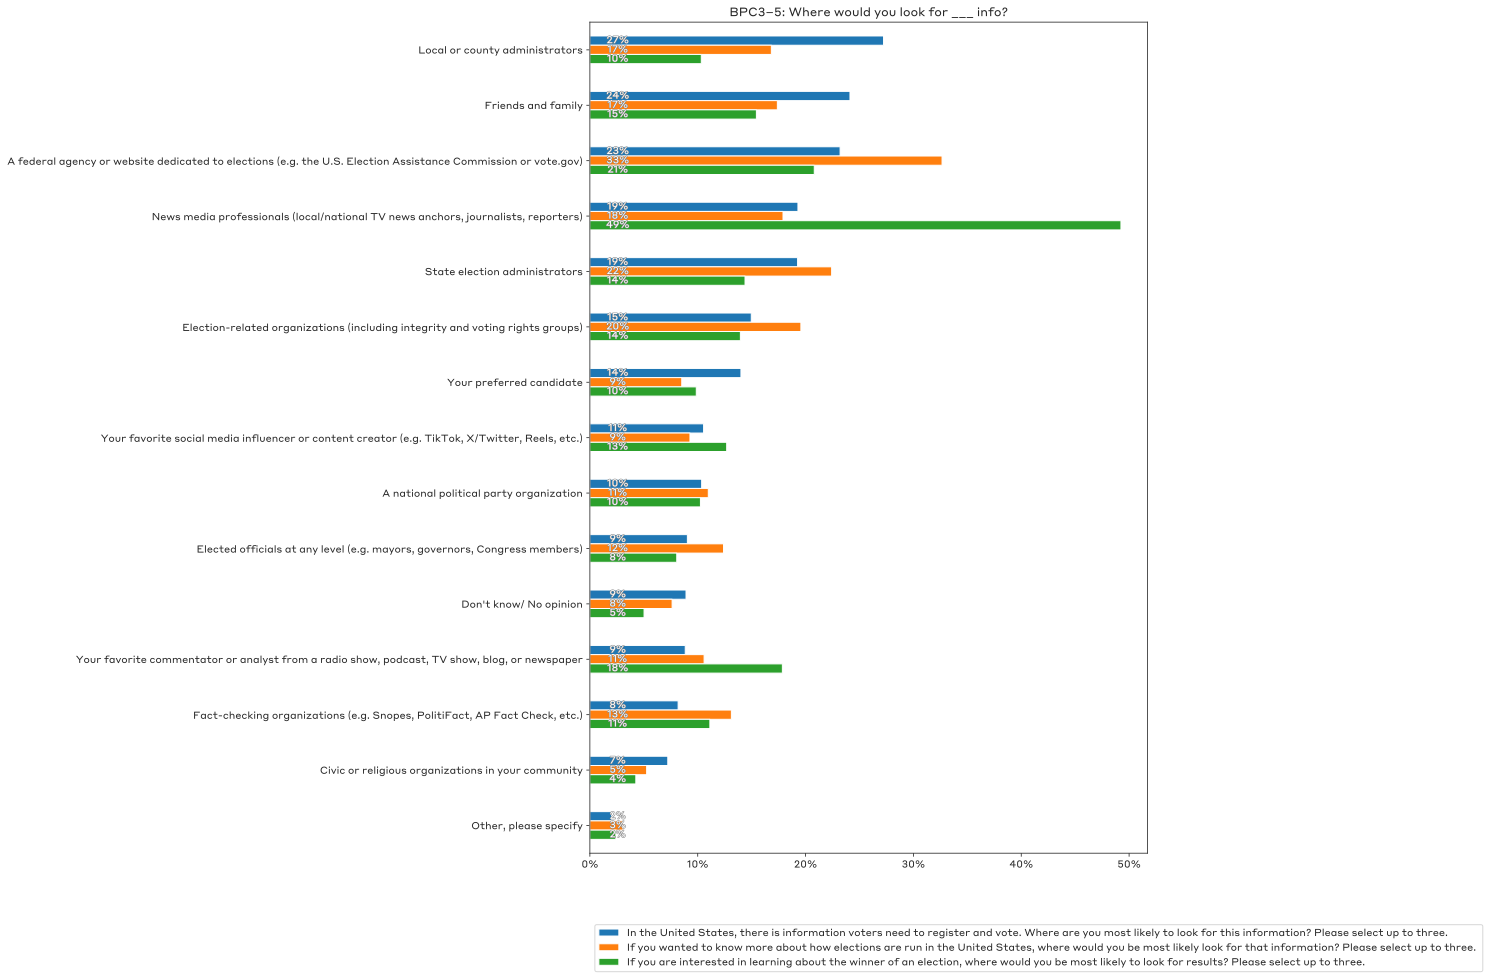

In [43]:
questions = [f"BPC{j}" for j in range(3, 6)]

final_df = mc_processor.get_parallel_questions(data, codebook, q_codebook, questions, survey_year)
ax = visualizing.plot_question(final_df, 'BPC3–5', 'Where would you look for ___ info?')

final_df = final_df.sort_values(by=final_df.columns[0],ascending=False).map(lambda x: f"{x:.1%}")
# display(final_df)
final_df.to_csv("2024/charts/info_topthree.csv")

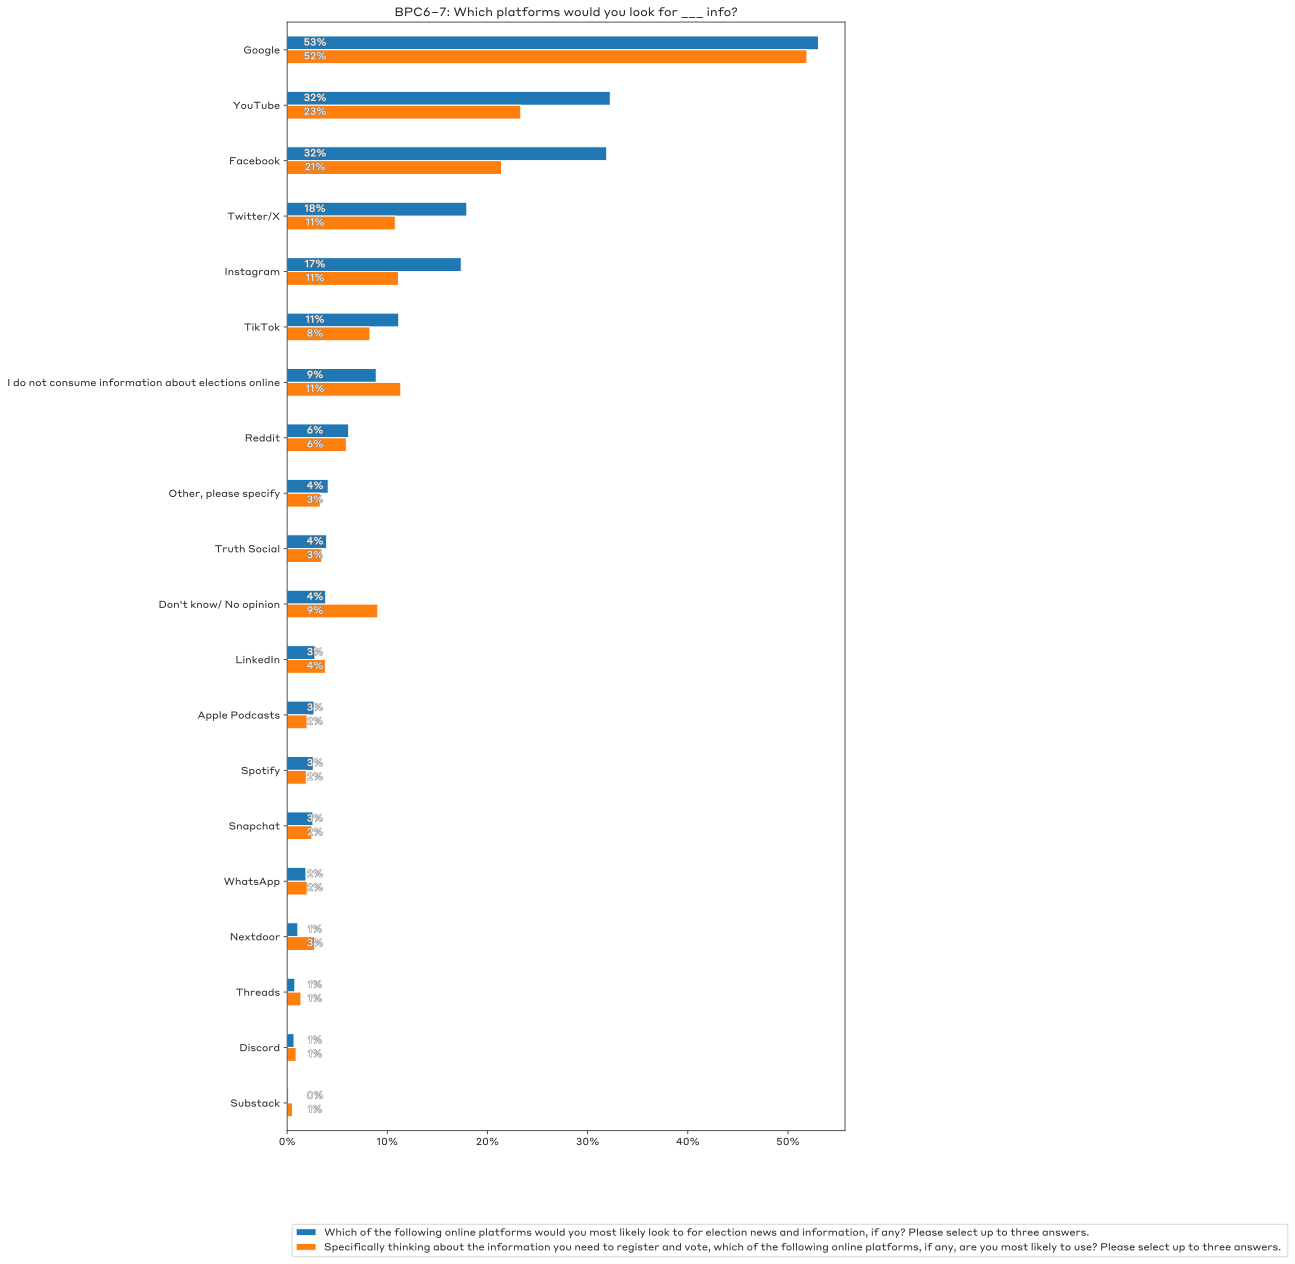

In [44]:
questions = [f"BPC{j}" for j in range(6, 8)]

final_df = mc_processor.get_parallel_questions(data, codebook, q_codebook, questions, survey_year)

ax = visualizing.plot_question(final_df, 'BPC6–7', 'Which platforms would you look for ___ info?')

final_df = final_df.sort_values(by=final_df.columns[0],ascending=False).map(lambda x: f"{x:.1%}")
# display(final_df)
final_df.to_csv("2024/charts/online_platforms.csv")

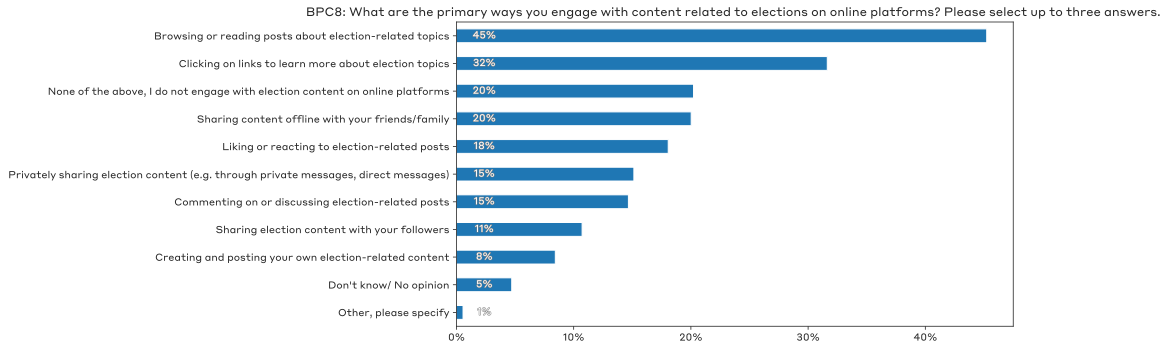

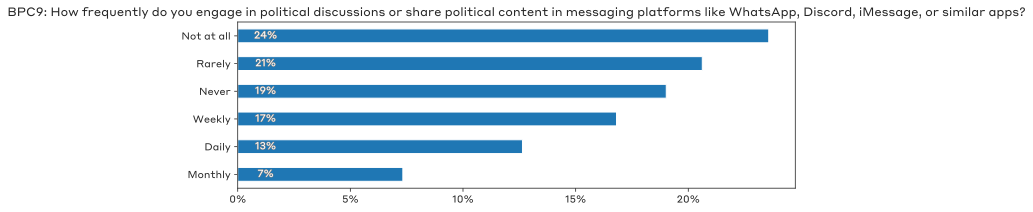

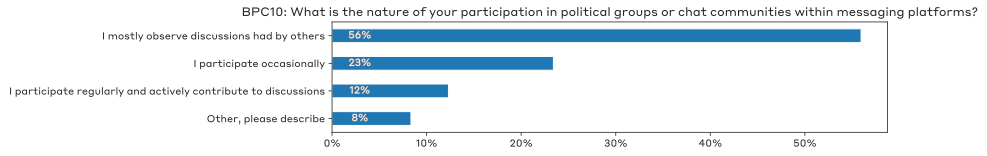

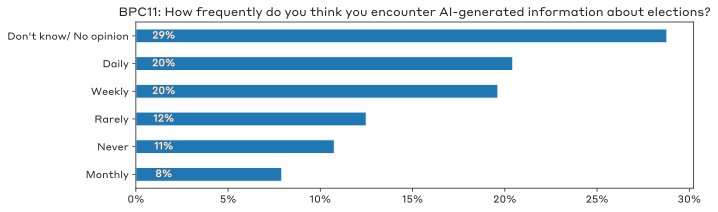

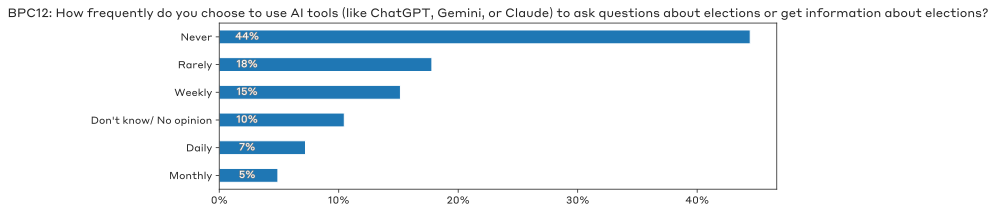

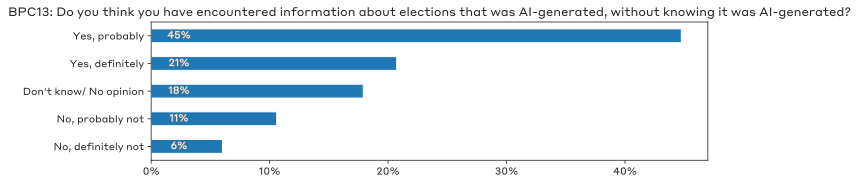

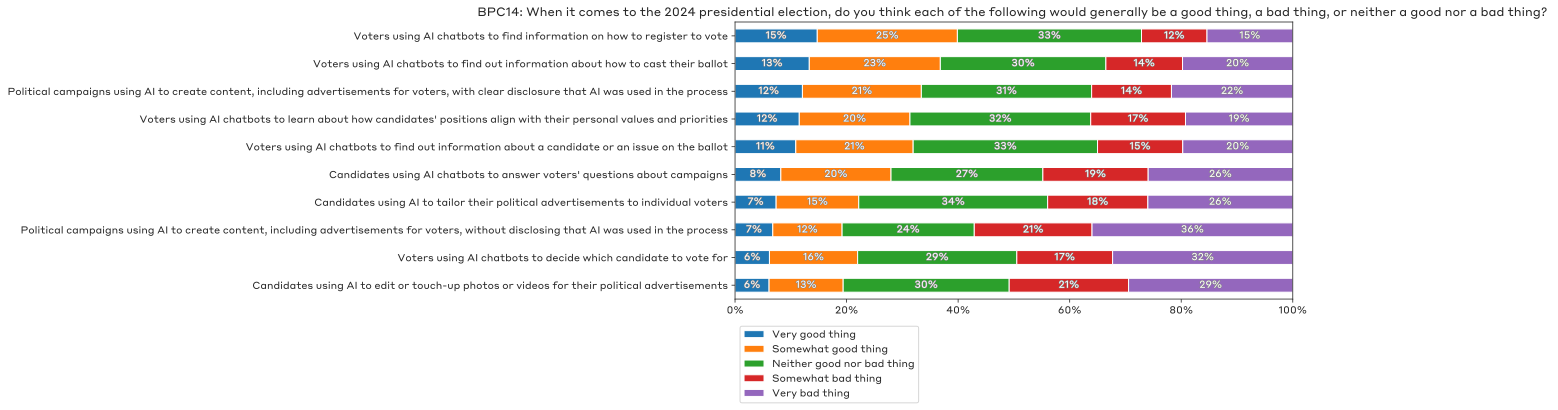

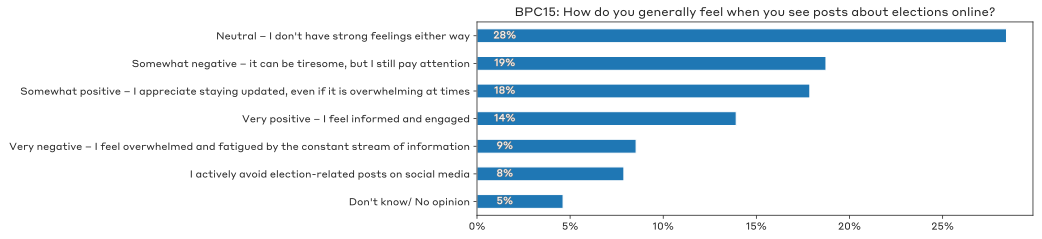

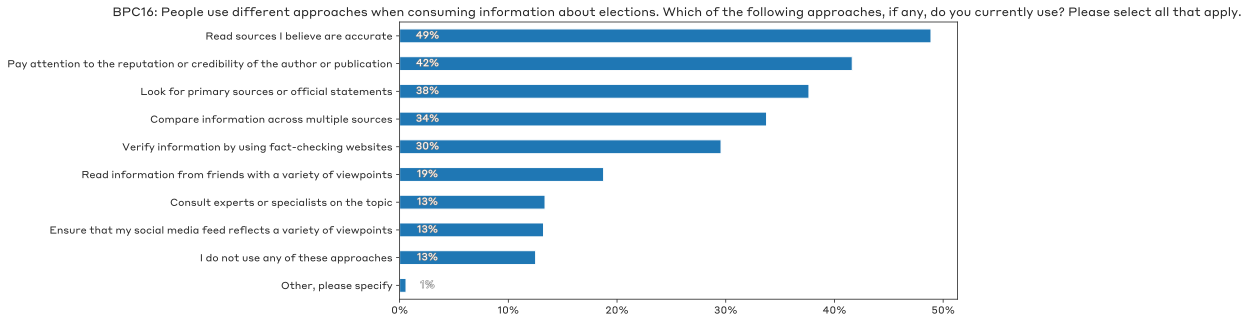

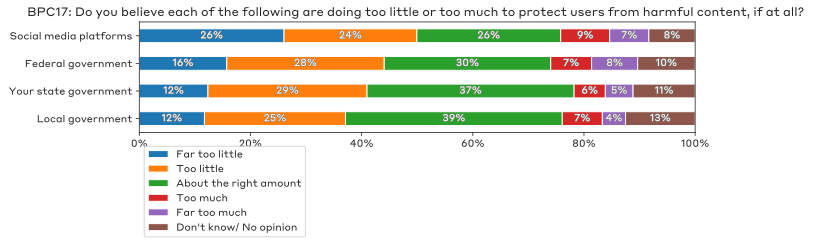

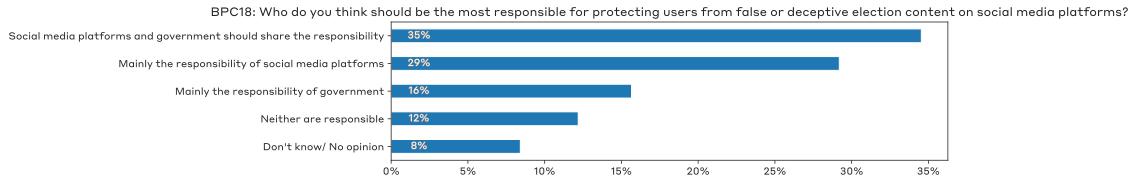

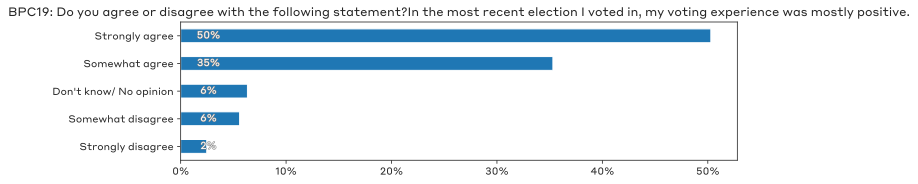

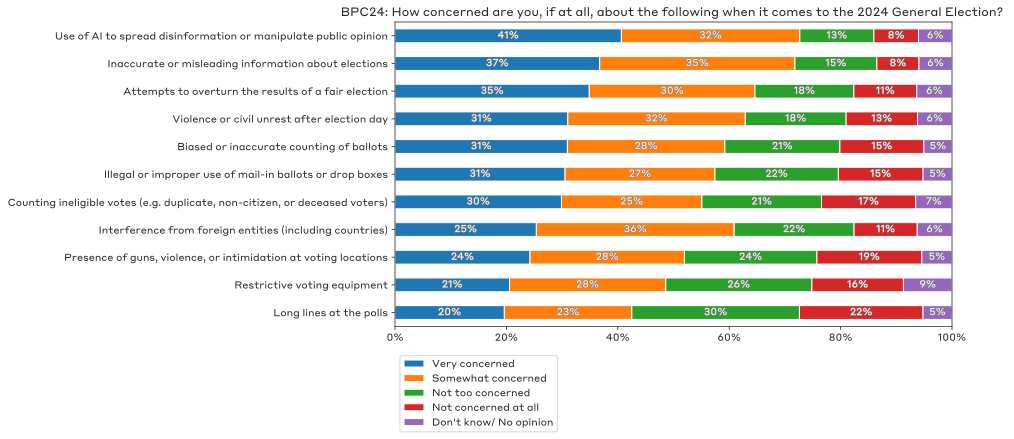

In [45]:
questions = [f"BPC{i}" for i in range(8, 20)] + ['BPC24']

for question in questions:
     df = mc_processor.run_and_display(data,codebook,q_codebook,question,survey_year,demo,suppress_output=False)


# Single use code / misc

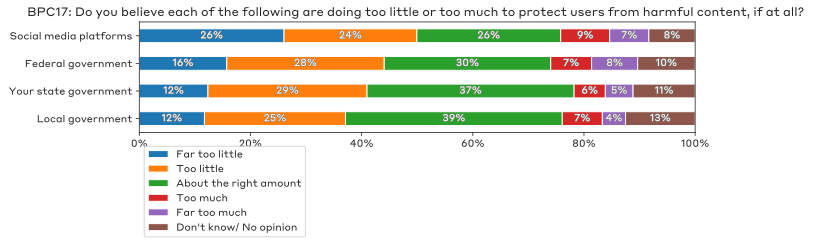

In [60]:
df = mc_processor.run_and_display(data,codebook,q_codebook,'BPC17',survey_year,demo,suppress_output=False)


In [120]:
df.loc[party]

Far too little  Too little  About the right amount  \
Social media platforms        0.260345    0.239069                0.258706   
Your state government         0.123545    0.286176                0.372470   
Federal government            0.157398    0.283246                0.299556   
Local government              0.117241    0.253705                0.390038   

                        Too much  Far too much  Don't know/ No opinion  
Social media platforms  0.088147      0.070419                0.083314  
Your state government   0.056270      0.049854                0.111685  
Federal government      0.073526      0.082870                0.103404  
Local government        0.072084      0.041733                0.125199

In [124]:
df.columns
df.columns = df.

Index(['Far too little', 'Too little', 'About the right amount', 'Too much',
       'Far too much', 'Don't know/ No opinion', '(far) too little',
       '(far) too much'],
      dtype='object')

Index(['(far) too little', 'About the right amount', '(far) too much',
       'Don't know/ No opinion'],
      dtype='object')

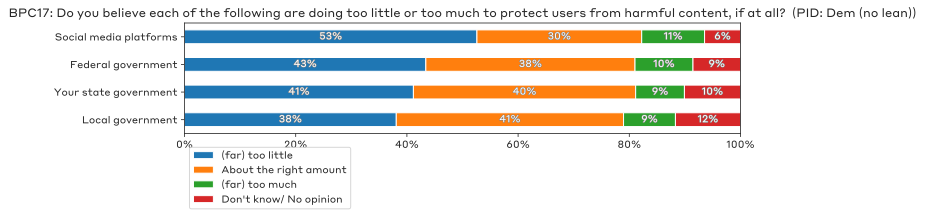

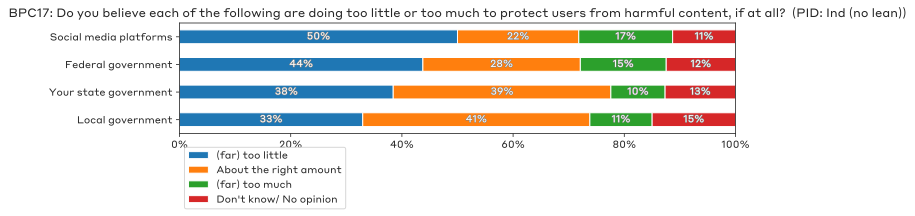

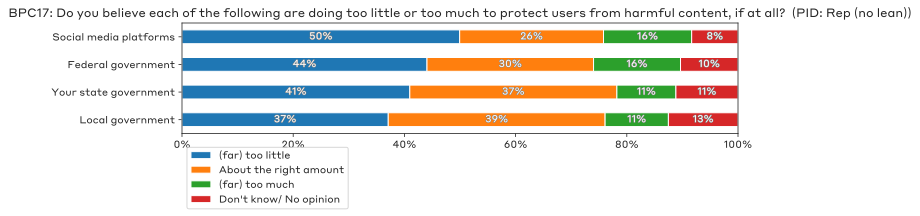

In [132]:
q = 'BPC17'
df = mc_processor.run_and_display(data,codebook,q_codebook,"BPC17",demo="xpid3",survey_year=survey_year,suppress_output=True, sort=False)
df = df.T
combined_little = '(far) too little'
combined_much = '(far) too much'
df[combined_little] = df['Too little'] + df['Far too little']
df[combined_much] = df['Too much'] + df['Far too much']
# df.columns = df.columns[[-2, 2, -1, 5]]
df = df.drop(columns=['Far too little', 'Too little', 'Too much', 'Far too much'])
df = df[[combined_little, 'About the right amount', combined_much, "Don't know/ No opinion"]]

for party in parties:
    visualizing.plot_question(df.loc[party], q, f"{mc_processor.get_question_text(q_codebook, q)} ({party})")

In [116]:
df['(far) too little'] = df['Too little'] + df['Far too little']
df['(far) too much'] = df['Too much'] + df['Far too much']

In [117]:
df

Far too little  Too little  \
PID: Dem (no lean) Social media platforms        0.270281    0.255689   
                   Your state government         0.100301    0.311405   
                   Federal government            0.117469    0.316584   
                   Local government              0.092892    0.287992   
PID: Ind (no lean) Social media platforms        0.218243    0.281739   
                   Your state government         0.092169    0.292219   
                   Federal government            0.118440    0.319297   
                   Local government              0.079751    0.249805   
PID: Rep (no lean) Social media platforms        0.260345    0.239069   
                   Your state government         0.123545    0.286176   
                   Federal government            0.157398    0.283246   
                   Local government              0.117241    0.253705   

                                           About the right amount  Too much  \
PID: Dem (no lean) Social media platforms                0.296349  0.072320   
                   Your state government                 0.399727  0.057188   
                   Federal government                    0.376225  0.047978   
                   Local government                      0.408759  0.064231   
PID: Ind (no lean) Social media platforms                0.218144  0.109571   
                   Your state government                 0.391435  0.046676   
                   Federal government                    0.283184  0.111250   
                   Local government                      0.408516  0.071546   
PID: Rep (no lean) Social media platforms                0.258706  0.088147   
                   Your state government                 0.372470  0.056270   
                   Federal government                    0.299556  0.073526   
                   Local government                      0.390038  0.072084   

                                           Far too much  \
PID: Dem (no lean) Social media platforms      0.040733   
                   Your state government       0.030517   
                   Federal government          0.056283   
                   Local government            0.029107   
PID: Ind (no lean) Social media platforms      0.059244   
                   Your state government       0.050865   
                   Federal government          0.043217   
                   Local government            0.040451   
PID: Rep (no lean) Social media platforms      0.070419   
                   Your state government       0.049854   
                   Federal government          0.082870   
                   Local government            0.041733   

                                           Don't know/ No opinion  \
PID: Dem (no lean) Social media platforms                0.064629   
                   Your state government                 0.100862   
                   Federal government                    0.085461   
                   Local government                      0.117019   
PID: Ind (no lean) Social media platforms                0.113059   
                   Your state government                 0.126635   
                   Federal government                    0.124612   
                   Local government                      0.149932   
PID: Rep (no lean) Social media platforms                0.083314   
                   Your state government                 0.111685   
                   Federal government                    0.103404   
                   Local government                      0.125199   

                                           Too little combined  
PID: Dem (no lean) Social media platforms             0.525969  
                   Your state government              0.411706  
                   Federal government                 0.434053  
                   Local government                   0.380884  
PID: Ind (no lean) Social media platforms             0.499983  
         

In [108]:

# Summing "Too little" and "Far too little"
df_transposed['Too little combined'] = df_transposed['Too little'] + df_transposed['Far too little']

# Summing "Too much" and "Far too much"
df_transposed['Too much combined'] = df_transposed['Too much'] + df_transposed['Far too much']



,PID: Dem (no lean),PID: Dem (no lean),PID: Dem (no lean),PID: Dem (no lean),PID: Ind (no lean),PID: Ind (no lean),PID: Ind (no lean),PID: Ind (no lean),PID: Rep (no lean),PID: Rep (no lean),PID: Rep (no lean),PID: Rep (no lean)
,Social media platforms,Your state government,Federal government,Local government,Social media platforms,Your state government,Federal government,Local government,Social media platforms,Your state government,Federal government,Local government
Far too little,0.270280623095164,0.10030069182193288,0.11746948945469797,0.0928921167276019,0.21824337007108385,0.0921692198230138,0.11844014114773323,0.07975073682147461,0.26034510993136756,0.12354530792282066,0.157397521957231,0.11724075096699553
Too little,0.25568871552055367,0.31140549264691963,0.3165839352125862,0.287991665434728,0.2817392292504041,0.2922189118320974,0.3192972509985638,0.2498047809704605,0.23906875455187077,0.28617556820327017,0.28324615671050396,0.2537053218768935
About the right amount,0.2963490875

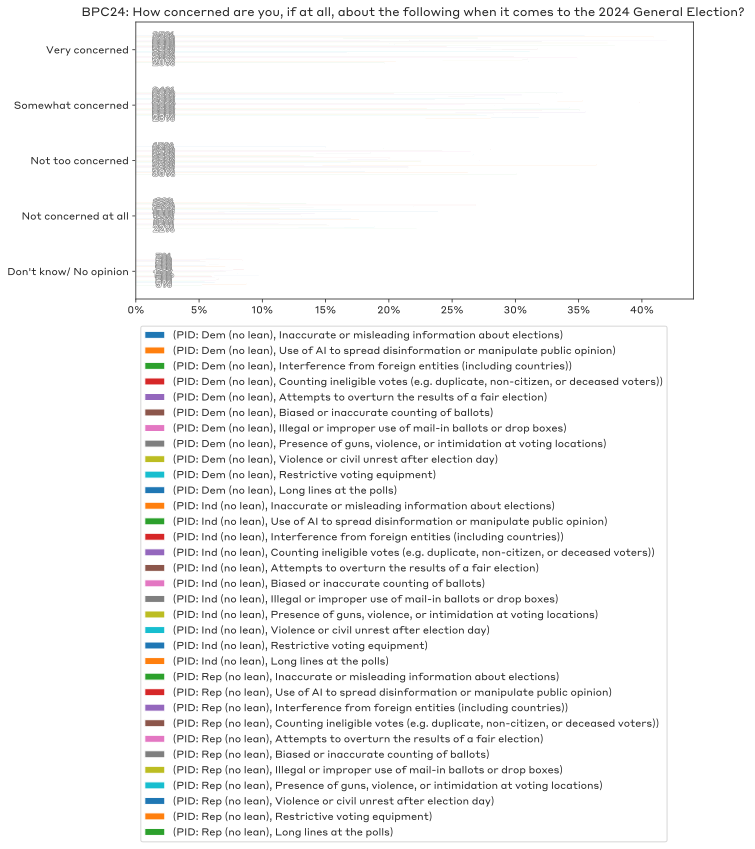

In [54]:
df = mc_processor.run_and_display(data,codebook,q_codebook,question,survey_year,demo='xpid3',suppress_output=True)


In [35]:
# feelings23 = pd.read_csv("2023/feelings.csv",index_col=0)
# feelings23.index = [i.replace("it's", "it is").replace("/n", "/ N").replace("Somewhat negative– It","Somewhat negative – it") for i in feelings23.index]
# feelings23.columns = ["2023"]
# feelings = mc_processor.run_and_display(data,codebook,q_codebook,"BPC15",survey_year,demo,suppress_output=True)
# feelings = pd.concat([feelings23,feelings],axis=1)

# visualizing.dotplot(feelings,"feelings",start_tick_title="Dec' 23",end_tick_title="Oct' 24",xlabel="Percent of Respondents")

# ## stopped working on this one -- adjusting axes messes up other formatting, needs some more attention
# # don't think it's the best visual anyways -- want to consider something different

In [36]:
# ### VISUALIZE CONFIDENCE BY DEMO

# confidence_keys = {20:"Your vote",21:"Votes in your local community",22:"Votes in your state",23:"Votes across the country"}

# dfs = {}

# for i in range(20, 24):
#     df = mc_processor.get_confidence_results(data, codebook, q_codebook, question_number=i, demo='xpid3', suppress_output=True)
#     dfs[confidence_keys[i]] = df

# demo_confidence = []
# for q in dfs:
#     df = dfs[q].T
#     demo_confidence.append(pd.DataFrame(df[["Very confident","Somewhat confident"]].sum(axis=1),columns=[q]))

# demo_confidence = pd.concat(demo_confidence,axis=1)
    
# demo_confidence =demo_confidence.T
# demo_confidence = demo_confidence.map(lambda x: f"{x:.1%}")
# # demo_confidence.to_csv("2024/charts/xpid_confidence.csv")

# # bpc colors
# bpc_blue = '#3C608A'
# bpc_lightgray = '#d3d8d6'
# bpc_darkgray = '#333638'
# bpc_red = '#e43e47'
# bpc_lightblue = '#3687e7'
# bpc_lightyellow = '#f6fbc2'
# bpc_lightpurple = '#ddafec'
# bpc_pink='#f87fab'
# bpc_orange='#eec044'

# # Function to add data labels to bars
# def add_labels(bars):
#     for bar in bars:
#         width = bar.get_width()
#         ax.text(width, bar.get_y() + bar.get_height() / 2, f'{width * 100:.0f}%', ha='left', va='center')

# # Set up the plot
# fig, ax = plt.subplots(figsize=(10, 6))

# # Define the positions for each bar
# bar_height = 0.2
# index = np.arange(len(demo_confidence))

# # Plot each group of bars
# bar1 = ax.barh(index - bar_height * 1.5, demo_confidence['PID: Dem (no lean)'], bar_height, label='PID: Dem (no lean)', color=bpc_blue)
# bar2 = ax.barh(index - bar_height / 2, demo_confidence['PID: Ind (no lean)'], bar_height, label='PID: Ind (no lean)', color=bpc_lightgray)
# bar3 = ax.barh(index + bar_height / 2, demo_confidence['PID: Rep (no lean)'], bar_height, label='PID: Rep (no lean)', color=bpc_red)
# bar4 = ax.barh(index + bar_height * 1.5, demo_confidence['overall'], bar_height, label='Overall', color=bpc_pink)

# # Call the function for each set of bars
# add_labels(bar1)
# add_labels(bar2)
# add_labels(bar3)
# add_labels(bar4)

# # Add labels and title
# ax.set_ylabel('Vote Confidence')
# ax.set_xlabel('Percentage (%)')
# ax.set_title('Confidence in Voting by Political ID')
# ax.set_yticks(index)
# ax.set_yticklabels(demo_confidence.index)

# # Add a legend
# ax.legend()

# # Display the plot
# plt.savefig("confidence_xpid.png")
# plt.show()